# 遗传算法:
遗传算法的核心是适应度函数，并对种群应用选择、交叉和突变这三种遗传算子。这里使用二进制编码、轮盘赌选择、单点交叉、一位取反突变，并事先为算法定义了进化次数作为结束条件。注意，遗传算法有可能落入局部最优。

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D

定义二进制码片长**12**位，种群大小**3000**，交叉率**0.8**，突变率**0.007**，*GA*运行**20**代后算法结束。参数需要根据自己选用的函数反复调整，如本模型选用函数中种群大小为**1000**时已经表现得非常好了，大小为**3000**时能基本保证每次运算结果精确到小数点后四位。

In [2]:
DNA_LENGTH = 12
POPULATION = 3000
CROSSOVER_RATE = 0.8
MUTATION_RATE = 0.007
GENERATIONS = 20
X_DOMAIN = [-3, 3]
Y_DOMAIN = [-3, 3]

选用二元函数$f(x,y)=3(1-x)^2e^{-x^2-(y+1)^2}-10(\frac{x}{5}-x^3-y^5)e^{-x^2-y^2}-\frac{1}{3^{e^{-(x+1)^2-y^2}}}$<br>该函数在$x\in[-3,3], y\in[-3, 3]$中有多个极大极小值，比较直观。可以根据自己的需要选用其他二元函数，注意修改对应的***X_DOMAIN,Y_DOMAIN***以达到较好的可视化效果。

In [3]:
def f(x, y):
    return 3 * (1-x)**2 * np.exp(-x**2-(y+1)**2) - 10 * (x/5-x**3-y**5) * np.exp(-x**2-y**2) - 1/(3**(np.exp(-(x+1)**2-y**2)))

三维图像可视化实现：<br>***np.linspace(start, stop, num)***方法返回区间***\[start,stop\]***中等间距的***num***个样本，其中***\****用于分配参数；<br>***np.meshgrid()***方法生成网格点坐标矩阵；<br>***ax.plot_surface(x, y, z, rstride, cstride, cmap)***方法用于绘制曲面图，其中参数***rstride, cstride, cmap***分别指定行列跨度和颜色映射；<br>注意如果在上一*Cell*中选用了自己的函数，需要根据函数取值通过***ax.set_zlim()***方法设置合适的$z$轴绘图范围。

In [4]:
def plot_3d(ax):
    x = np.linspace(*X_DOMAIN, 100)
    y = np.linspace(*Y_DOMAIN, 100)
    x, y = np.meshgrid(x, y)
    z = f(x, y)
    ax.plot_surface(x, y, z, rstride = 1, cstride = 1, cmap = cm.coolwarm)
    ax.set_zlim(-10, 10)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')
    plt.pause(1)

*DNA*的前半片对应$x$的取值，后半片对应$y$的取值，因此平面内的一个点可以由这样的*DNA*表示。对于码片，我们不关心具体的映射是什么，只需要将十进制的数编码为二进制即可，这里采用二进制串按权展开的解码方式。假设$n$位二进制码片$x_{n-1}x_{n-2}...x_0$，则对应的十进制数为$\sum_{i=0}^{n-1}{x_i*2^i}$。将得到的十进制数乘以$\frac{1}{2^n-1}$压缩为$[0,1]$间的一个浮点数，再乘以定义域长度，将其映射到我们需要的区间。码片长度不仅代表了精度，也会影响到后续训练中的效率。<br>注意***population***中的成员是一串*DNA*序列，***\[:,m:n\]***取其第一维的所有数据（即所有*DNA*码片），第二维的***\[m,n-1\]***列数据（即码片上下半分别对应$x,y$坐标的编码，*m=0*时可以省略）；***np.arange(stop)***方法生成***\[0,stop\)***区间内步长为1的序列，***a\[::-1\]***表示将***a***中所有元素逆置；通过***.dot()***方法作向量内积，完成解码。

In [5]:
def decode(population):
    x_population = population[:, :DNA_LENGTH]
    y_population = population[:, DNA_LENGTH:DNA_LENGTH * 2]
    x = x_population.dot(2 ** np.arange(DNA_LENGTH)[::-1]) / float(2 ** DNA_LENGTH - 1) * (X_DOMAIN[1] - X_DOMAIN[0]) + X_DOMAIN[0]
    y = y_population.dot(2 ** np.arange(DNA_LENGTH)[::-1]) / float(2 ** DNA_LENGTH - 1) * (Y_DOMAIN[1] - Y_DOMAIN[0]) + Y_DOMAIN[0]
    return x, y

适应度函数：种群的每个个体都应该有机会被选择，因而适应度函数值需要是一个正数，所以直接使用函数的取值作为适应度函数是不合适的。同时，注意原始函数$f(x,y)$存在正值和负值，因此适应度函数必须是单调的，否则算法只能求得绝对值最大的值而不能辨别极大值与极小值之间的符号区别。以极大值为例，最基本的做法是将函数的取值减去当前种群中取值的最小值，将其转化为非负数，再加上一个很小的数值以保证非0；对于极小值则是将函数取值减去当前种群中的最大值，取负后加上一个很小的数。这是一个合适的适应度函数，可以在大约50代左右求得较为满意的极值，但这并非一个最好的适应度函数，考虑以下两种优化方式：<p>1）使用幂指数函数作为适应性函数，如$2^{±f(x,y)}$。该函数能很好的确保适应度函数为正数的特性，并且由于幂指数放大了函数值之间的差距，算法可以较快收敛到极值。然而，这样的设计也带来了一个缺点，函数第一象限的部分上升很快，而第二象限的部分却过于平缓，这会让算法很快地“抛弃”了适应性函数值较小的个体，对应的*DNA*中却可能包含了将产生最大值的基因片段。采用这种做法，算法会收敛的很快，同时也很快地“抹杀”了种群的多样性，使得找到的极值不够完美，容易卡在接近顶峰（谷底）的位置；<p>2）设计一个迭代加深的函数，如$z^{\lfloor\frac{generation}{2}\rfloor*2+1}$（幂为奇数，因此是单调的；注意同样要做非0的处理）。在算法初期，个体间的适应性函数的差异不会太大，既能给予适应度高的个体更高的被选择的概率，又能给适应度低的个体不被立马“抹杀”的机会；进而，在算法后期，个体几乎全部集中在极值附近而使得适应度函数值差异不大时，加深的权值使得这些细小的差异被放大，形成概率差异，实现优中选优。

In [6]:
def get_fitness(population, generation):
    x, y = decode(population)
    z = f(x, y)
    # return (z - np.min(z)) + 1e-3
    # return -(z - np.max(z)) + 1e-3
    # return 2 ** z
    # return 2 ** (-z)
    return (z - np.min(z)) ** (generation // 2 * 2 + 1) + 1e-3
    # return -(z - np.max(z)) ** (generation // 2 * 2 + 1) + 1e-3

种群演变的过程如下，依次从原种群中取出每个个体，对其应用交叉算子及突变算子，产生新的个体，再将其加入新的种群。注意返回值需要用***np.array()***方法将*list*转换为*ndarray*数组。

In [7]:
def evolve(population):
    new_population = []
    for father in population:
        child = father
        apply_crossover(child)
        apply_mutation(child)
        new_population.append(child)
    return np.array(new_population)

交叉：采用单点交叉的方法，***np.random.randint(low, high)***方法返回一个***\[low,high\)***间的随机*np.int*型数（交叉点），将交叉点后的部分码片置为母个体（在原种群中用***np.random.randint()***方法随机选取，***high***不填时默认返回随机数的区间范围为***[0,low)***）对应位置的码片。注意交叉（可以）不是必然发生的，因此引入了交叉率的概念。***np.random.rand()***方法返回一个服从***[0,1)***均匀分布的样本随机值，当其大于交叉率时才应用交叉算子。

In [8]:
def apply_crossover(child):
    if np.random.rand() < CROSSOVER_RATE:
        mother = population[np.random.randint(POPULATION)]
        crossover_index = np.random.randint(0, DNA_LENGTH * 2)
        child[crossover_index:] = mother[crossover_index:]

突变：采用一位取反突变的方法，随机产生突变点，将该位置的二进制数取反，使新生个体的*DNA*产生来自父母之外的突变。注意突变的概率很低。

In [9]:
def apply_mutation(child):
    if np.random.rand() < MUTATION_RATE:
        mutation_index = np.random.randint(0, DNA_LENGTH * 2)
        child[mutation_index] = child[mutation_index] ^ 1

选择：采用轮盘赌法，种群中第$i$个个体$S_i$有$\frac{f_i}{\sum{f}}$的概率被选中，其中$f_i$是个体$S_i$的适应度，$\sum{f}$是当前种群的总体适应度。<br>***np.random.choice(a, size=None, replace=True, p=None)***方法，从*ndarray*数组***a***中按概率***p***抽取元素，组成大小为***size***的新数组，参数***replace***指定是否可以有重复元素；<br>***np.arange()***方法生成原种群下标序列，对其应用***np.random.choice()***方法取得被选择的下标，对应元素组成新的种群。

In [10]:
def apply_selection(population, fitness):
    survival_index = np.random.choice(np.arange(POPULATION), size = POPULATION, replace = True, p = fitness / fitness.sum())
    return population[survival_index]

输出遗传算法结束时的代数、种群数、适应度函数值、*DNA*码片、$x,y,z$坐标等信息。***np.argmax()***方法返回*ndarray*数组中最大值的索引值。

In [11]:
def print_information(population):
    fitness = get_fitness(population, GENERATIONS)
    max_index = np.argmax(fitness)
    print("fitness: ", fitness[max_index])
    x, y = decode(population)
    print("DNA: ", population[max_index])
    print("(x, y, z) = ", x[max_index], y[max_index], f(x[max_index], y[max_index]))

主函数：<br>使用*matplotlib*绘制动图（*jupyter*中貌似没有办法展示动态的图片，把每个代码*Cell*中的内容复制到如*Geany, PyCharm*等*IDE*中执行即可）<br>*matplotlib*中有两种显示模式：<br>1）阻塞模式：必须用***plt.show()***显示图片，且图片关闭之前代码将阻塞在该行；<br>2）交互模式：立即显示图片，不阻塞代码的继续运行；<br>***fig = plt.figure()***与***ax = Axes3D(fig)***定义图像和三维格式坐标轴；<br>***plt.ion()***方法打开交互模式；<br>***np.random.randint()***方法随机生成二进制表示的初始种群；<br>将二进制*DNA*码片解码后使用***ax.scatter(x, y, z, c, marker)***方法对每一代绘制散点图（其中参数***c***表示散点颜色，***marker***表示散点形状），注意绘图时需要将上一代已经绘制的点去掉，定义***sca***为***ax.scatter()***的返回对象，***locals()***方法以字典类型返回当前位置的全部局部变量，如果***sca***在局部变量中则删除；<br>***plt.pause()***方法控制每张图片展示（即逐帧动画）的时间间隔；<br>应用交叉、突变、选择算子，循环进入下一代直到算法结束；<br>***plt.ioff()***方法关闭交互模式；<br>***plt.show()***方法使图像停留在算法执行结束。

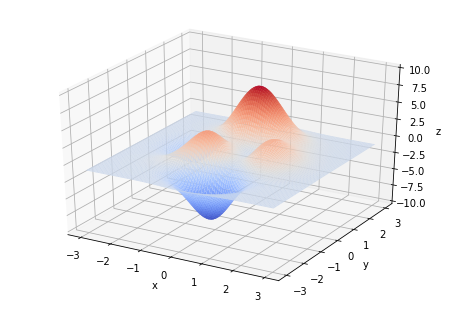

generation:  20
population:  3000
fitness:  106550.43687321205
DNA:  [0 1 1 1 1 1 1 1 0 1 0 1 1 1 0 0 0 0 1 1 0 1 0 0]
(x, y, z) =  -0.01538461538461533 1.577289377289377 7.150190475275718


In [21]:
if __name__ == "__main__":
    fig = plt.figure()
    ax = Axes3D(fig)
    plt.ion()
    plot_3d(ax)
    population = np.random.randint(2, size = (POPULATION, DNA_LENGTH * 2))
    for generation in range(GENERATIONS):
        x, y = decode(population)
        if 'sca' in locals():
            sca.remove()
        sca = ax.scatter(x, y, f(x, y), c = 'magenta', marker = 'o')
        plt.pause(0.02)
        population = evolve(population)
        fitness = get_fitness(population, generation)
        population = apply_selection(population, fitness)
    print("generation: ", GENERATIONS)
    print("population: ", POPULATION)
    print_information(population)
    plt.ioff()
    plt.show()